In [1]:
import numpy as np
import sys
import os
import matplotlib.pyplot as plt
import pickle

# Define the path to the src directory manually
src_path = os.path.abspath('../../../src')
sys.path.insert(0, src_path)

from module_tidal import TidalData
from module_rotor import RotorData
from module_rotor_simulation import RotorSimulation
from module_vessel import VesselData
from module_lcoe import LCOE
from module_constraint_checker import ConstraintChecker


from constUnitConvert import ConstantsUnitConversion
from constGlobal import ConstantsGlobal

CONVERT = ConstantsUnitConversion()
GLOBAL = ConstantsGlobal()


# Use color-blind friendly style
plt.style.use('tableau-colorblind10')

# Load tidal data
pick a site

/Users/akeow/opt/anaconda3/envs/VITAL_env/lib/python3.12/site-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'proxy.sandia.gov'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/Users/akeow/opt/anaconda3/envs/VITAL_env/lib/python3.12/site-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'proxy.sandia.gov'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/Users/akeow/opt/anaconda3/envs/VITAL_env/lib/python3.12/site-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'proxy.sandia.gov'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#t

Buoy lat:56.6765 degree
Buoy lon:-133.7325 degree
City lat:56.9653 degree
City lon:-134.1564 degree
City lat:0.9942320443863258 radian
City lon:-2.3414708926225205 radian
Buoy lat:0.9891915335065662 radian
Buoy lon:-2.3340724419233165 radian


Text(0, 0.5, 'flow [m/s]')

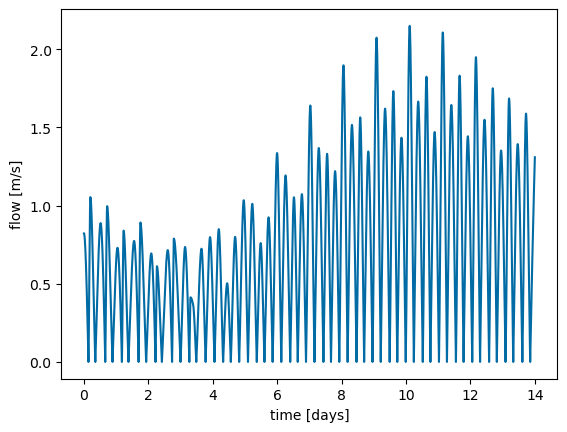

In [2]:
station = "PCT3716"  # Site 2
startdate = 20200201  # yyyyMMdd
rangeHr = 2 * 7 * 24  # Two weeks
timestep = 5.0  # Timestep in seconds

tidal_data = TidalData(station, startdate, rangeHr, timestep)
flow_speeds, times, dmoor_m, lat_rad, lon_rad, station_name, nearest_city, cable_length = tidal_data.load_tidal_data("../../../data/AlaskaCityLatLong.txt")

plt.plot(times/(24*3600),flow_speeds)
plt.xlabel('time [days]')
plt.ylabel('flow [m/s]')



# Configure Turbine and Simulate

In [3]:
# Define simulation parameters
config = {
    'Radius': 1.0,
    'Prated': 1000.0,
    'dCable': 10.0,
    'dMoor': dmoor_m,
    'Uinf': flow_speeds,
    't': times,
    'CpFunc': None,  # Placeholder, will be set later
    'CqFunc': None,  # Placeholder, will be set later
    'CtFunc': None,  # Placeholder, will be set later
    'CpOpt': None,  # Placeholder, will be set later
    'TSROpt': None,  # Placeholder, will be set later
    'Umin': 0.1,
    'withBrake': True,
    'control_strategy': 'constant_speed',
    'attachment_method': 'cable'
}

# Initialize RotorData class
rotor_filename = "../../../data/Sitkana_rotor_data_blade_1.txt"
rotor_data = RotorData(rotor_filename)

# Set Cp, Cq, and Ct functions from RotorData class
config['CpFunc'] = rotor_data.get_cp
config['CqFunc'] = rotor_data.get_cq
config['CtFunc'] = rotor_data.get_ct

# Set CpOpt and TSROpt from RotorData class
config['CpOpt'] = rotor_data.CpOpt
config['TSROpt'] = rotor_data.TSROpt
config['TSRmax'] = rotor_data.TSRmax
config['efficiency'] = 0.9

# # Define the parameter values to vary
# radius_values = [0.5, 1.0, 1.5, 2.0]
# prated_values = [1.0e3, 5.0e3, 10.0e3, 20.0e3]
# dcable_values = [6.0, 10.0, 14.0, 18.0]


            
# rotor_sim = RotorSimulation(config)
# rotor_sim.simulate()
# result = rotor_sim.get_results()



In [4]:
import os
import re
import pickle

# Define the parameter values to vary
radius_values = [0.5, 1.0, 1.5, 2.0]
prated_values = [1.0e3, 2.5e3, 5.0e3, 10.0e3, 20.0e3]
dcable_values = [2.0, 4.0, 6.0, 8.0, 10.0, 12.0, 14.0, 16.0, 18.0]

# Directory where the .pkl files are saved (current directory)
output_directory = os.getcwd()

# List all .pkl files in the directory
pkl_files = [f for f in os.listdir(output_directory) if f.endswith('.pkl')]
pattern = re.compile(r'simulation_results_R([0-9.]+)_P([0-9.]+)_D([0-9.]+)\.pkl')

results = []

# Run simulations for each combination of parameters
for radius in radius_values:
    for prated in prated_values:
        for dcable in dcable_values:
            output_filename = f"simulation_results_R{radius}_P{prated}_D{dcable}.pkl"
            
            # Check if the file already exists
            if os.path.exists(output_filename):
                print(f"File {output_filename} already exists. Skipping simulation.")
                continue
            
            # Update configuration
            config['Radius'] = radius
            config['Prated'] = prated
            config['dCable'] = dcable
            
            # Run the simulation
            rotor_sim = RotorSimulation(config)
            rotor_sim.simulate()
            result = rotor_sim.get_results()
            results.append(result)

            # Save results to file
            with open(output_filename, 'wb') as f:
                pickle.dump(result, f)
                print(f"Results saved to {output_filename}.")


File simulation_results_R0.5_P1000.0_D2.0.pkl already exists. Skipping simulation.
File simulation_results_R0.5_P1000.0_D4.0.pkl already exists. Skipping simulation.
File simulation_results_R0.5_P1000.0_D6.0.pkl already exists. Skipping simulation.
Optimal Speed is 2.378776758417225
Results saved to simulation_results_R0.5_P1000.0_D8.0.pkl.
File simulation_results_R0.5_P1000.0_D10.0.pkl already exists. Skipping simulation.
Optimal Speed is 2.378776758417225
Results saved to simulation_results_R0.5_P1000.0_D12.0.pkl.
File simulation_results_R0.5_P1000.0_D14.0.pkl already exists. Skipping simulation.
Optimal Speed is 2.378776758417225
Results saved to simulation_results_R0.5_P1000.0_D16.0.pkl.
File simulation_results_R0.5_P1000.0_D18.0.pkl already exists. Skipping simulation.
Optimal Speed is 2.378776758417225
Results saved to simulation_results_R0.5_P2500.0_D2.0.pkl.
Optimal Speed is 2.378776758417225
Results saved to simulation_results_R0.5_P2500.0_D4.0.pkl.
Optimal Speed is 2.37877675

In [5]:
print(results)

[{'t': array([0.000000e+00, 5.000000e+00, 1.000000e+01, ..., 1.209585e+06,
       1.209590e+06, 1.209595e+06], shape=(241920,)), 'w': array([2.37877676, 2.37877676, 2.37877676, ..., 2.37877676, 2.37877676,
       2.37877676], shape=(241920,)), 'Tc': array([12.45383122, 12.45381211, 12.4537548 , ..., 79.31552714,
       79.38879465, 79.46209102], shape=(241920,)), 'Pmech': array([ 29.62488426,  29.62483881,  29.62470247, ..., 188.67393255,
       188.8482196 , 189.02257528], shape=(241920,)), 'Pelec': array([ 26.66239583,  26.66235493,  26.66223222, ..., 169.80653929,
       169.96339764, 170.12031776], shape=(241920,)), 'Phydro': array([ 29.62488426,  29.62483881,  29.62470247, ..., 188.67393255,
       188.8482196 , 189.02257528], shape=(241920,)), 'Pfluid': array([223.56262675, 223.56246616, 223.56198446, ..., 901.16024081,
       902.03181643, 902.90376164], shape=(241920,)), 'Punc': array([ 47.22313365,  47.22309973,  47.22299798, ..., 190.35207767,
       190.53618059, 190.7203615